In [1]:
import networkx as nx
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from collections import Counter

%matplotlib inline
%load_ext autoreload
%autoreload 2

seaborn.set_context('paper')
seaborn.set_style('white')

In [2]:
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.impute_reassortant_status(G)
G = cf.clean_host_species_names(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [3]:
# How many human-to-human circulation clusters are found?

def same_host_descent(G, host_species):
    """
    Returns the nodes that are involved in same-host transmission.
    """
    nodes = set()  # nodes that are involved in human-human transmission.
    for sc, sk, d in G.edges(data=True):
        sc_host = G.node[sc]['host_species']
        sk_host = G.node[sk]['host_species']
        
        sc_subtype = G.node[sc]['subtype']
        sk_subtype = G.node[sk]['subtype']
        
        subtype_exclusions = ['Mixed', 'mixed']
        
        not_mixed = (sc_subtype not in subtype_exclusions) and (sk_subtype not in subtype_exclusions)
        is_clonal = d['edge_type'] == 'full_complement'
        
        if sc_host == host_species and sk_host == host_species and not_mixed and is_clonal:
            nodes.add(sc)
            nodes.add(sk)

    return nodes

In [4]:
hh_nodes = same_host_descent(G, 'Human')
cc_nodes = same_host_descent(G, 'Chicken')
ss_nodes = same_host_descent(G, 'Swine')

In [5]:
# What are the subtypes of the nodes that are involved in human-human chains?

def subtype_counts(node_set, log=False):

    subtypes = Counter()
    for n in node_set:
        subtype = G.node[n]['subtype']
        subtypes[subtype] += 1

    if log:
        for k, v in subtypes.items():
            subtypes[k] = np.log10(v)
            
    return subtypes

In [6]:
hh_subtypes = subtype_counts(hh_nodes, log=True)
ss_subtypes = subtype_counts(ss_nodes, log=True)
cc_subtypes = subtype_counts(cc_nodes, log=True)

In [7]:
hh_subtypes

Counter({'H10N8': 0.6020599913279624,
         'H1N1': 3.6866362692622934,
         'H1N2': 1.255272505103306,
         'H3N2': 3.5613399414589013,
         'H5N1': 1.505149978319906,
         'H7N9': 1.0})

In [8]:
def plot_subtype_counts(subtype_counter, ax, title, color, log=False):
    width = 0.8
    ax.bar(np.arange(0, len(subtype_counter)), subtype_counter.values(), width=width, color=color)
    ax.set_xlim(0, len(subtype_counter))
    ax.set_xticks(np.arange(len(subtype_counter)) + width/2)
    ax.set_xticklabels([k for k in subtype_counter.keys()], ha='right', rotation=45)
    if log:
        ylabel = 'log10 num. nodes'
    else:
        ylabel = 'Num. of nodes'
    ax.set_ylabel(ylabel)
    ax.set_title(title)

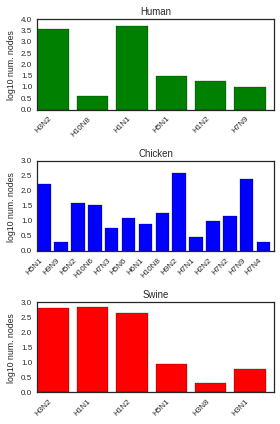

In [9]:
fig = plt.figure(figsize=(4, 6))
hh_ax = fig.add_subplot(311)
plot_subtype_counts(hh_subtypes, ax=hh_ax, title='Human', color='green', log=True)

cc_ax = fig.add_subplot(312)
plot_subtype_counts(cc_subtypes, ax=cc_ax, title='Chicken', color='blue', log=True)

ss_ax = fig.add_subplot(313)
plot_subtype_counts(ss_subtypes, ax=ss_ax, title='Swine', color='red', log=True)
plt.tight_layout()

plt.savefig('figures/Clonal Descent.pdf')

In [10]:
sorted(hh_subtypes.items(), key = lambda x:x[1])

[('H10N8', 0.6020599913279624),
 ('H7N9', 1.0),
 ('H1N2', 1.255272505103306),
 ('H5N1', 1.505149978319906),
 ('H3N2', 3.5613399414589013),
 ('H1N1', 3.6866362692622934)]